<a href="https://colab.research.google.com/github/dorbittonn/Human-Activity-Recognition-/blob/main/GC_HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ALMA Human Activity Recognision mission



In [2]:
# Setup
%matplotlib inline
import os
import sys
import time
import torch
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import torch.nn as nn

warnings.simplefilter("ignore")

In [3]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# load dataset
from pandas import read_csv
import numpy as np

# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
                       
# Load a dataset and return a 3-D numpy array
def load_dataset(group):   
    path = "\\."
    acc_x = load_file( r"body_acc_x_" + group +".txt")
    acc_y = load_file( r"body_acc_y_" + group +".txt")
    acc_z = load_file( r"body_acc_z_" + group +".txt")

    gyro_x = load_file( r"body_gyro_x_" + group +".txt")
    gyro_y = load_file( r"body_gyro_y_" + group +".txt")
    gyro_z = load_file( r"body_gyro_z_" + group +".txt")

    X_df = np.dstack([acc_x ,acc_y ,acc_z ,gyro_x ,gyro_y ,gyro_z ])
    y_df  = load_file( r"./" + group + '/y_' + group + '.txt')
    return X_df, y_df

X_train, y_train = load_dataset('train')
X_test, y_test = load_dataset('test')
                       
S = X_train.shape[1]
print( X_train.shape, X_test.shape, y_train.shape, y_test.shape)

FileNotFoundError: ignored

In [19]:
BATCH_SIZE = 32

# labels are 1-6 so in order to use NLLL pytorch functions we need to subtract 1 for every label.
# label 0 for example is equal to predict the 1'st label, etc.
ds_X_train = torch.utils.data.TensorDataset(torch.tensor(X_train.astype('double')), 
                                            torch.tensor(y_train.astype('double'))- torch.ones(size=(X_train.shape[0],1))
                                           )

# Split train to validation and train 80-20
lengths = [int(len(ds_X_train)*0.8), len(ds_X_train) - int(len(ds_X_train)*0.8)]
ds_train, ds_valid = torch.utils.data.random_split(ds_X_train, lengths)
ds_X_test = torch.utils.data.TensorDataset(torch.tensor(X_test), torch.tensor(y_test))


dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_valid =  torch.utils.data.DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_X_test, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
print(f'num batches: {len(dl_train)} \ndatasets sizes :{len(ds_X_train)} ,{len(ds_valid)} ,{len(ds_X_test)}')

x0, y0 = next(iter(dl_train))
print(f'shape of a batch of samples: {x0.shape}')
print(f'shape of a batch of labels: {y0.shape}')

num batches: 184 
datasets sizes :7352 ,1471 ,2947
shape of a batch of samples: torch.Size([32, 128, 6])
shape of a batch of labels: torch.Size([32, 1])


## Lets Visualize the data to get some feeling about it:

In [129]:
from matplotlib import pyplot

# group data by activity
def data_by_activity(X, y, activities):
    # group windows by activity
    return {a:X[y[:,0]==a, :, :] for a in activities}

# convert a series of windows (every 128 sequence is a window) to a 1D list
def to_series(windows):
    series = list()
    # for every sequence
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

# plot histograms for each activity for every feature
def plot_activity_histograms(X, y, flag):
    # get a list of unique activities for the subject
    activity_ids = np.unique(y[:,0])
    # group by activity
    grouped = data_by_activity(X, y, activity_ids)
    # plot per activity, histograms for each axis 
    pyplot.figure(figsize= (16,16))
    acts = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
    for k, act in enumerate(acts):
        act_id = activity_ids[k]
        # if flag is up plot gyro measurements , else plot accelarator
        params = list([3,4,5]) if flag else list([0,1,2])
        xaxis = None
        for i in params:
            ax = pyplot.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
            ax.hist(to_series(grouped[act_id][:,:,i]), bins=100, alpha=0.5)
            pyplot.title('activity '+ act, loc='left')
            ax.set_xlim(-1.2,1.2)

            if flag:
                pyplot.legend(['Gyro-x','Gyro-y','Gyro-z'], fontsize=12)
                ax.set_xlabel('rad/sec')

            else:
                pyplot.legend(['Body Acc-x','Body Acc-y','Body Acc-z'], fontsize=12)
                ax.set_xlabel('g')
                
    pyplot.tight_layout(pad=1.0)
    pyplot.show()


According to the plots above, we can pay attention to the fact each activity has a different data distribution.
Data distribution for the first three activities looks Gaussian with varying mean & std.
Distribution over the latter 3 activites looks much less homogenous, like delta functions in the mean. 



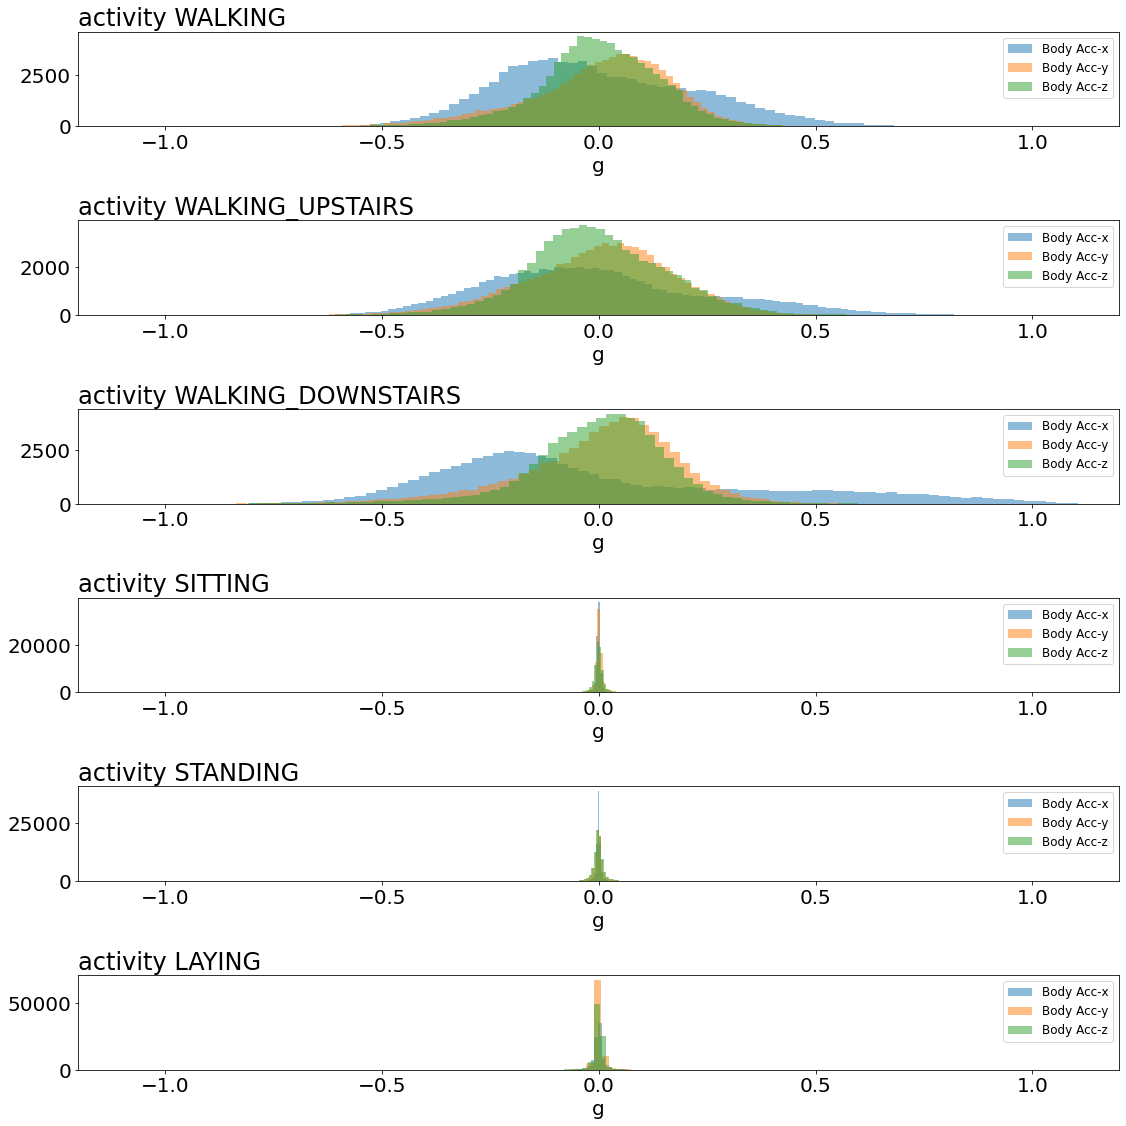

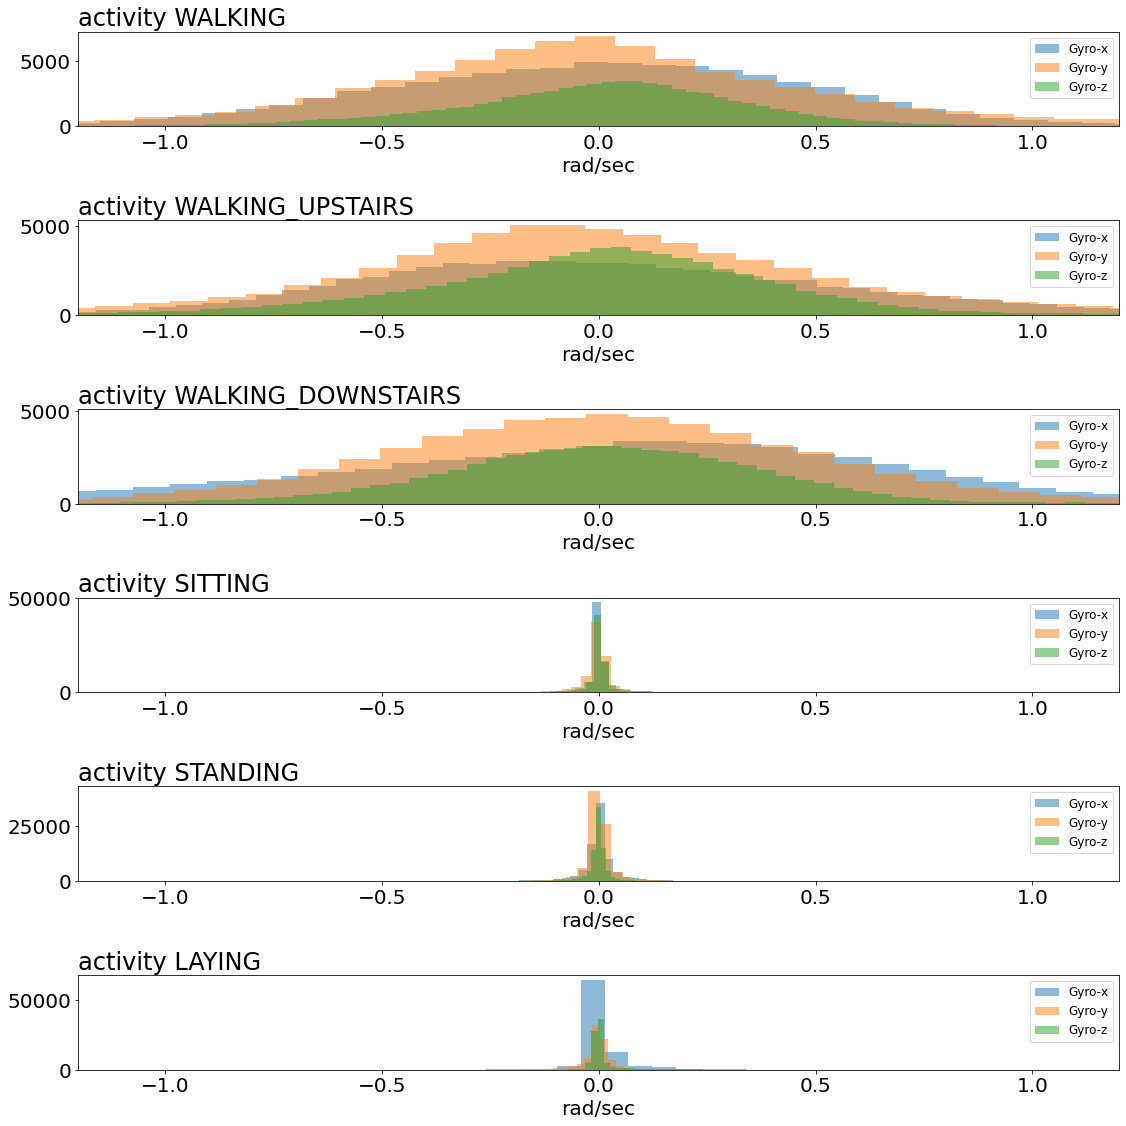

In [ ]:
# First plot Accelerators
plot_activity_histograms(X_train, y_train, 0)
# Then plot Gyro
plot_activity_histograms(X_train, y_train, 1)


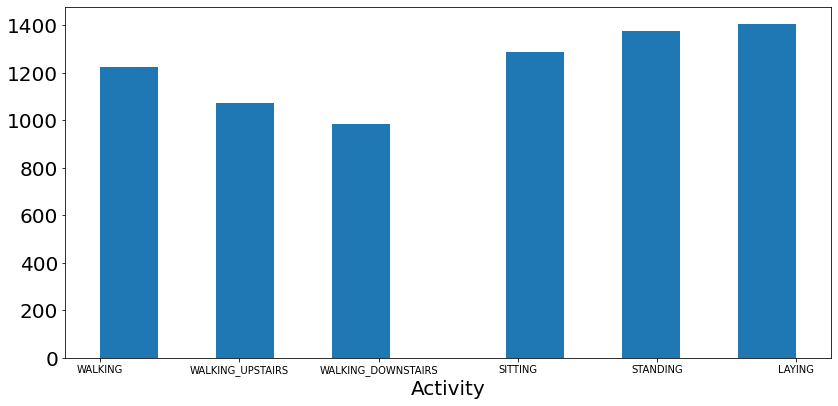

In [ ]:
# Check dataset balance

acts = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(y_train, bins=12)
ax.set_xlabel('Activity')
ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], fontsize=10)
fig.tight_layout(pad=1.0)
fig.show()

Due to the histogram above we can see that the training set is relatively balance - this is important because we dont want our predicions to be biased.

(316, 128, 6) (316, 1)


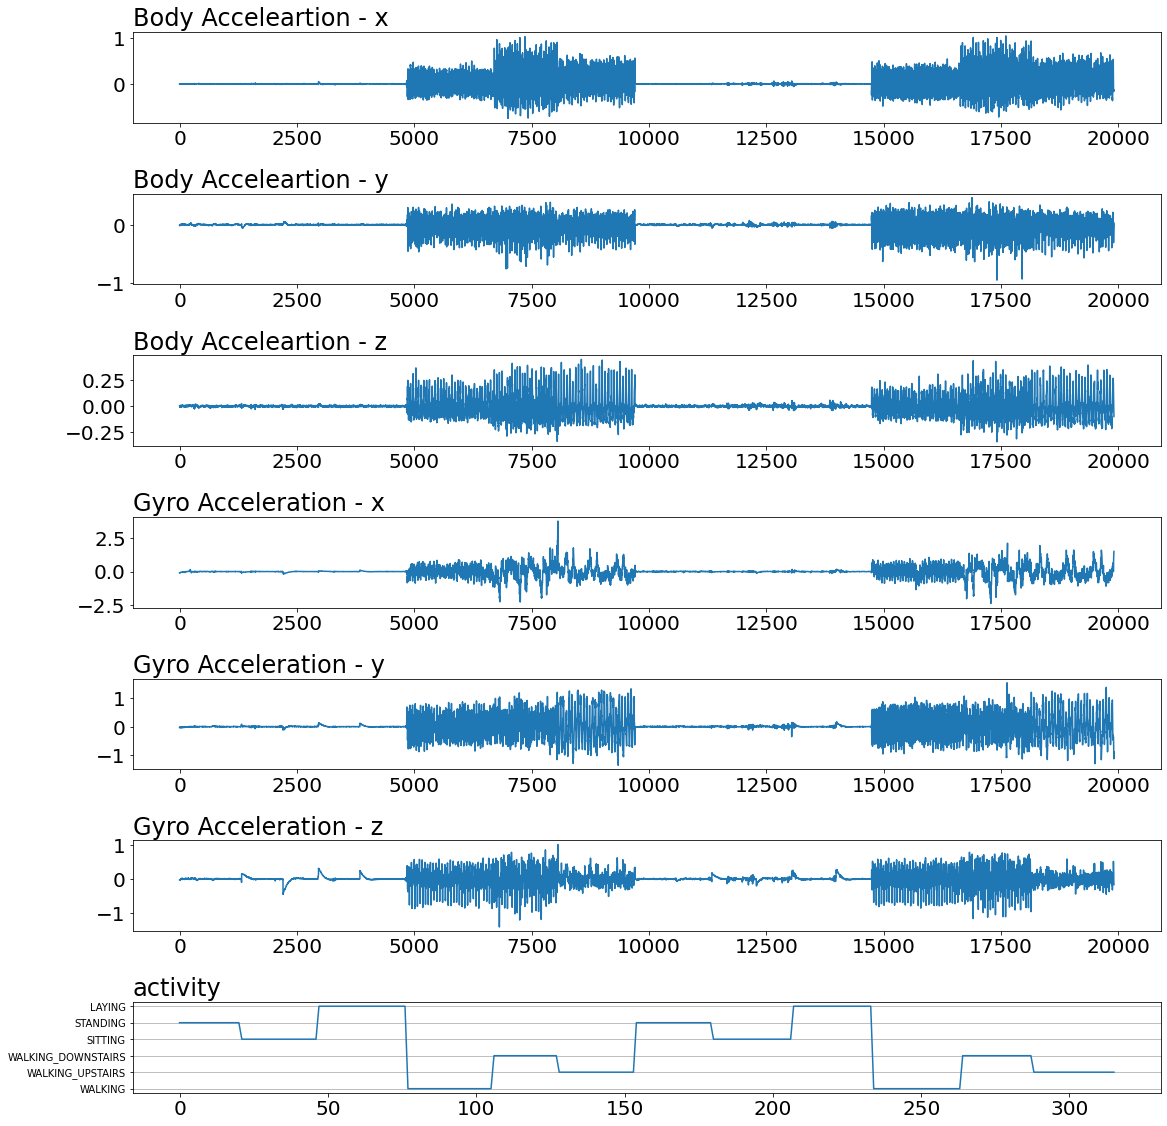

In [ ]:
def plot_subject(X,y):
    pyplot.figure(figsize= (16,16))
    vocab = {0:'x',1:'y',2:'z'}
    for i in range(3):
        pyplot.subplot(7, 1, i+1)
        pyplot.plot(to_series(X[:,:,i]))
        pyplot.title(f"Body Acceleartion - {str(vocab[i%3])}", loc='left')
    for i in range(3,6):
        pyplot.subplot(7, 1, i+1)
        pyplot.plot(to_series(X[:,:,i]))
        pyplot.title(f"Gyro Acceleration - {str(vocab[i%3])}", loc='left')
    ax = pyplot.subplot(7,1,7)
    pyplot.tight_layout(pad=1.0)
    
    ax.set_yticks([1,2,3,4,5,6])
    ax.set_yticklabels(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], fontsize=10)
    pyplot.grid(axis='y')
    
    pyplot.plot(y)
    pyplot.title('activity', loc = 'left')
    pyplot.show()
    
def data_of_subject(X,y,sub_map,sub_id):
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    return X[ix,:,:], y[ix]

# lets see how the activites looks over time of one certain subject (number 11).
subject_map = load_file(data_path +  r'\train' + r"\subject_train.txt")
X11, y11 = data_of_subject(X_train, y_train, subject_map, 11)
print(X11.shape,y11.shape)
plot_subject(X11,y11)

from the subject's point of view we can actually see that different activites cause different results to the Gyro and the body accelerations.
for example when walking Laying almost all of the parameters are low. In addition we can see that the Body acceleration in Z axis is very noisy when climbing downstairs/upstairs , which make sense intuitively.


### Classic ML approach - K-Nearest Neighbor

KNN is one of the most popular algorithms for pattern recognition. The classifiers do not use any model to fit and only based on memory.
The traditional K-NN classification algorithm has few limitations:


1. calculation complexity due to the usage of all the training samples for classification.
2. the preformance is solely dependent on the training set
3. There is no weight difference between samples.


The second visualization actually made me chose KNN since it looks like different activities really has a specific range of values and behavior than the others.
Usually we would like to use K-fold CV to select k and other hyper-parameters , but here since its a TimeSeries mission, we'll prefer using TimeSeriesSplit of sklearn which takes into account the order of the dataset.


for example:
- fold1: training 1 validation 2
- fold2: training 1,2 validation 3
- fold3: training 1,2,3 validation 4 etc...

In [ ]:
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit,KFold
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
grid_params ={
    'n_neighbors': [1],
    'weights':['uniform', 'distance'],
    'metric':['euclidean','manhattan']
}

tscv=TimeSeriesSplit(n_splits=20)
#tscv=KFold(n_splits=3)

gs = GridSearchCV(
    model,
    grid_params,
    verbose = 1,
    cv = tscv,
    scoring = 'accuracy'
)

#print(len(np.unique(subject_map)))

gs.fit(X_train.reshape(X_train.shape[0],-1), y_train)
print(gs.best_score_, gs.best_estimator_)



Fitting 20 folds for each of 4 candidates, totalling 80 fits
0.6592857142857144 KNeighborsClassifier(metric='manhattan', n_neighbors=1)


Top 1 Test Set Accuracy - 0.68%


(<Figure size 792x576 with 2 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

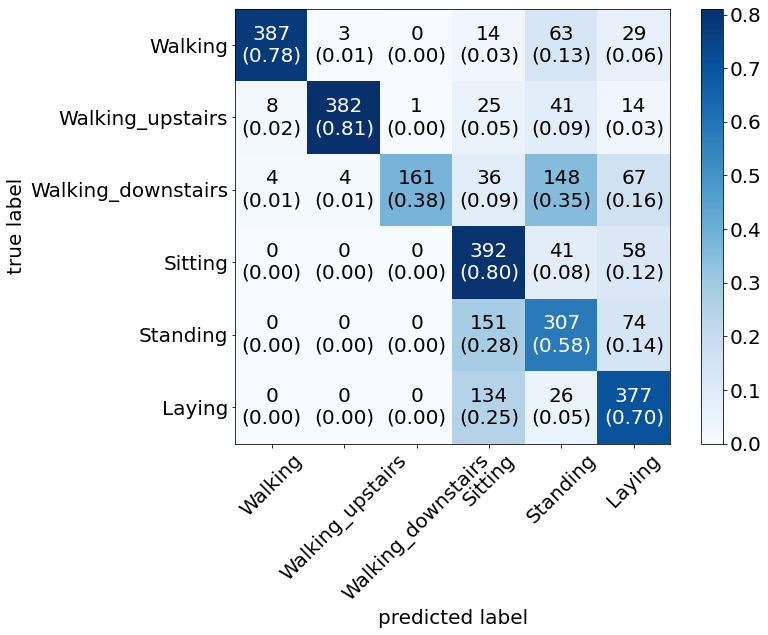

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score

labels = ['Walking', 'Walking_upstairs', 'Walking_downstairs', 'Sitting', 'Standing', 'Laying']

y_pred = gs.best_estimator_.predict(X_test.reshape(X_test.shape[0],-1))
mat = confusion_matrix(y_test, y_pred)
acc = mat.trace()/np.sum(mat)
# f1 score macro uses the unwieghted mean of the classes f1_scores (1 against rest)
F1 = f1_score(y_test, y_pred, average='macro')

print(f"Top 1 Test Set Accuracy - {acc:.2f}% F1-score - {F1:.2f} ")
plot_confusion_matrix(conf_mat = mat, class_names = labels, show_normed=True, figsize=(11, 8), colorbar=True )

### Deep Learning approach - LSTM based neural network

For missions of sequence processing our first choice could be the simple RNN based network, but such networks usually having difficulties with learning long term temporal dependecies - which here could be crucial important for the task. This is because of the loss function decays exponentially in time (vanishing gradients). LSTM units include a 'memory cell' that can maintain information in emory for long periods of time.
LSTMs have a seperate update and forget gate, this clearly makes them more sophisticated & complex as well.
Compared to GRU, they should in theory remember longer sequences and outperform them in tasks requiring modeling long-distance relations.




In [21]:
def train(model ,optimizer ,scheduler ,loss_fn ,dl_train ,dl_test ,max_epochs=100 ,
          num_batches=400, print_every=1, save_path=None, early_stop_patience=10):
    count = 0 #early stopping counter
    best_test_acc = 0
    res = FitResult(max_epochs,[],[],[],[] )
    
    for epoch_idx in range(max_epochs):
        if count == early_stop_patience:
            print("----- Early stopping activated -----")
            return res
        count += 1
        total_loss, num_correct = 0, 0
        num_samples = 0
        start_time = time.time()
        
        for batch_idx, batch in enumerate(dl_train):
            X, y = batch
            # change shape (B,S,F ) -> (S,B,F)
            X = X.transpose(0,1).to(device)
            y = y.squeeze().long().to(device)

            # Forward pass
            _, y_pred_log_proba = model(X)
            
            # Backward pass
            optimizer.zero_grad()
            #print(y_pred_log_proba.shape,y_pred_log_proba.dtype , y.dtype, y.shape)
            loss = loss_fn(y_pred_log_proba, y)
            loss.backward()

            # Weight updates
            optimizer.step()
            
            # Calculate accuracy
            total_loss += loss.item()
            y_pred = torch.argmax(y_pred_log_proba, dim=1)
            num_samples += y_pred.shape[0]
            num_correct += torch.sum(y_pred == y).float().item()

            if batch_idx == num_batches-1:
                break
        
        curr_test_loss, curr_test_acc = test_epoch(model, loss_fn, dl_test, print_acc=(epoch_idx % print_every == 0))
        res.test_loss.append(curr_test_loss)
        res.test_acc.append(curr_test_acc)
        
        curr_train_loss = total_loss /(num_batches)
        curr_train_acc = num_correct /(num_samples)
        res.train_loss.append(curr_train_loss)
        res.train_acc.append(curr_train_acc)

        

        if epoch_idx % print_every == 0:
            print(f"Epoch #{epoch_idx}, loss={curr_train_loss:.3f}, accuracy={curr_train_acc:.3f}, elapsed={time.time()-start_time:.1f} sec")
        
        if save_path and curr_test_acc > best_test_acc:
            count = 0 
            print(f"---saving model ---, test_acc = {curr_test_acc:.3f}")
            torch.save(model, save_path)
            best_test_acc = curr_test_acc

        scheduler.step(best_test_acc)

    return res

In [22]:
def test_epoch(model, loss_fn, dataloader, print_acc=False):
    model.eval()
    total_loss = 0
    num_correct = 0 
    num_batches = 0
    num_samples = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            num_batches = batch_idx
            X, y = batch
            X = X.transpose(0,1).to(device)
            y = y.squeeze().long().to(device)
            
            _, y_test = model(X)
            loss = loss_fn(y_test, y)
            total_loss += loss.item()
            
            # Calculate accuracy
            y_pred = torch.argmax(y_test, dim=1)
            num_correct += torch.sum(y_pred == y).float().item()
            num_samples += y_pred.shape[0]

        num_batches += 1   
        
        test_loss = total_loss /(num_batches)
        test_acc = num_correct /(num_samples)
        if print_acc:
            print(f"Test Accuracy={test_acc:.3f} Test Loss={test_loss:.3f}")

    model.train()
    return test_loss, test_acc


In [23]:
class LSTM(nn.Module):
    def __init__(self,input_size=8, num_classes=6, hidden_size=128, num_layers=3, dropout=.0):
        super().__init__()
        
        self.lstm = torch.nn.LSTM(input_size=input_size,
                                hidden_size=hidden_size,
                                num_layers=num_layers,
                                dropout=dropout)

        # LSTM output shape after taking last layer at last time step is (B, hidden_size),
        # we need a dense layer to get class scores from it
        self.dense_linear = torch.nn.Sequential(torch.nn.Linear(hidden_size, num_classes),
                                                torch.nn.Dropout(p=dropout),
                                                torch.nn.ReLU())

        # To convert class scores to log-probability we'll apply log-softmax
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, X):
        # LSTM input should be (S, B, F)
        _, (h_n, _) = self.lstm(X)
        
        # we only need the last hidden state at the last time step 
        # h_n is (num_layers, B, hidden_dim)
        class_scores = self.dense_linear(h_n[-1, :, :])
        
        # class scores is (B, classes_num)
        log_prob = self.log_softmax(class_scores)
        
        final_class = torch.argmax(class_scores, dim=1)

        # log prob shape is (B, Classes)
        return final_class, log_prob


In [24]:
from typing import NamedTuple,List
class FitResult(NamedTuple):
    """
    Represents the result of fitting a model for multiple epochs given a
    training and test (or validation) set.
    The losses are for each batch and the accuracies are per epoch.
    """

    num_epochs: int
    train_loss: List[float]
    train_acc: List[float]
    test_loss: List[float]
    test_acc: List[float]

In [25]:
import torch.optim.lr_scheduler as sch


# droput 0.5 numlayers 1 - 66%
# dropout 0.5 numlayers 2 - 65%
# dropout 0.5 numlayers 2 with schedulerOnPlateu after 10 epochs decrease multiply by 0.1 start lr=1e-3- 50%
# dropout 0.7 numlayers 2 with schedulerOnPlateu after 10 epochs decrease multiply by 0.1 start lr=1e-4- 45%
# dropout 0.5 numlayers 1 with schedulerOnPlateu after 5 patience by 0.1 startlr=1e-3 - 59%
# dropout 0.8 numlayers 1 with schedulerOnPlateu after 5 patience by 0.1 startlr=1e-3 - 65 %
# dropout 0.4 numlayers 3 with hidden 16 and schedulerOnPlateu after 5 patience by 0.5 startlr=1e-3 -48%
# dropout 0.4 numlayers 3 , hidden dim 32 with schedulerOnPlateu after 5 patience by 0.5 startlr=1e-3 - 66%
# dropout 0.5 numlayers 1 , hidden dim 32 with schedulerOnPlateu after 5 patience by 0.5 startlr=1e-3 - 64 Bathces - 63%

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0
BETAS = (0.95, 0.98)


In [ ]:
for d in [0.4,0.6,0.8]:
    for h in [16, 32, 64]:
        for l in [1,2,3]:
#for (l,h,d) in [(3 ,32 ,0.8),(2 ,32 ,0.4),(3, 32, 0.4), (1 ,16 ,0.6), (1,16,0.8)]:
            print(f"\n----- layers = {l}------ dropout = {d} , hidden = {h} -------")
            
            modellstm = LSTM(input_size=6, num_layers=l, hidden_size=h, dropout =d).double().to(device)

            optimizer = torch.optim.Adam(modellstm.parameters(),
                                        lr=LEARNING_RATE,
                                        weight_decay=WEIGHT_DECAY,
                                        )

            # We'll use the ReduceLRonPlateau scheduler to help converge to the best optima ny smaller steps as long
            # as training process.
            scheduler = sch.ReduceLROnPlateau(optimizer, mode='max',factor=0.5, patience=5, verbose=True)

            loss_fn = torch.nn.NLLLoss()
            
            # train on training set and evaluate on validation set.
            fit_res = train(modellstm ,optimizer ,scheduler ,loss_fn, dl_train, dl_valid, max_epochs=200,
                  num_batches=500, save_path = f"./LSTM_{l,d,h}.pt", print_every=10)


----- layers = 1------ dropout = 0.4 , hidden = 16 -------
Test Accuracy=0.198 Test Loss=1.786
Epoch #0, loss=0.659, accuracy=0.179, elapsed=5.6 sec
---saving model ---, test_acc = 0.198
---saving model ---, test_acc = 0.320
---saving model ---, test_acc = 0.379
---saving model ---, test_acc = 0.390
---saving model ---, test_acc = 0.397
---saving model ---, test_acc = 0.406
---saving model ---, test_acc = 0.436
Test Accuracy=0.438 Test Loss=1.521
Epoch #10, loss=0.590, accuracy=0.334, elapsed=5.6 sec
---saving model ---, test_acc = 0.438
Epoch    17: reducing learning rate of group 0 to 5.0000e-04.
Test Accuracy=0.432 Test Loss=1.442
Epoch #20, loss=0.578, accuracy=0.324, elapsed=5.5 sec
----- Early stopping activated -----

----- layers = 2------ dropout = 0.4 , hidden = 16 -------
Test Accuracy=0.341 Test Loss=1.769
Epoch #0, loss=0.658, accuracy=0.193, elapsed=11.0 sec
---saving model ---, test_acc = 0.341
Epoch     7: reducing learning rate of group 0 to 5.0000e-04.
Test Accuracy=

In [ ]:
modellstm = LSTM(input_size=6, num_layers=2, hidden_size=16, dropout =0.6).double().to(device)

optimizer = torch.optim.Adam(modellstm.parameters(),
                            lr=LEARNING_RATE,
                            weight_decay=WEIGHT_DECAY,
                            )

# We'll use the ReduceLRonPlateau scheduler to help converge to the best optima ny smaller steps as long
# as training process.
scheduler = sch.ReduceLROnPlateau(optimizer, mode='max',factor=0.5, patience=5, verbose=True)

loss_fn = torch.nn.NLLLoss()


# train on training set and evaluate on validation set.
fit_res = train(modellstm ,optimizer ,scheduler ,loss_fn, dl_train, dl_valid, max_epochs=100,
      num_batches=500, save_path = f"./LSTM__.pt", print_every=2)

In [ ]:
### 

### Task preformance boosting

In order to improve the task's preformance we can use different architectures for the neural network such as TCNs, TCNs are a relatively new architecture for processing Time-Series tasks.
The main drawback of the LSTMs is that they are relatively slow to train.
The temporal Convolutional Networks are not only faster but also produced greater accuracy in 9 cases out of 11 in Shaojie Bai, J. Zico Kolter, and Vladlen Koltun'S [Paper](https://arxiv.org/pdf/1803.01271.pdf).
TCNs uses mainely dilated convolution, in a causal way (since we want the learn the present from the past, excluding the future.
As deep as the input being processed through the network , the dilation increases, this allows you to learn relation even from the far past.

- The temporal convolutional networks allows massive parallelism that shoetens both training and evaluation cycles.
- Lower memory requirement for training, especially in the case of long input sequences.
- stable gradients - unlike recurrent architectures, TCN has a backpropagation path different from the temporal direction of the sequence, TCN thus avoids the problem of exploding/vanishing gradients whichi is a major issue for RNNs (including LSTMs GRUs)

Another possible way of boosting the task's preformance is by applying multiheaded attention mechanism. This type of mechnism could allow us learn connections between different parts inside the sequence. 




In [ ]:
####

### The Motivation behind using confusion matrix in Classification tasks:

The idea behind using confusion matrix in order to evaluate models prediction for classification tasks is observing the wrong predictions explicitly, and in this visualization you can estimated how "severe" your mistakes are.
For example if Im prediction Corona Virus existence according to patient's medical data, the False negatives might be more important for us than the False positives, since a sick patient will have to know about it whereas if healthy patient will think he is sick he will be able to re-check.

One can claim that that Top-1 accuracy metic is sufficient to evaluate a model, but for imbalanced data (which is the usual case when its about real-world-data), when the model predicts that each point belongs to the majority class label, the accuracy will be high, but the model is not accurate. 
Hence we need Confusion matrix, to break down the mistakes by each class(powerful especially in multicalss classification).

